# <center> Regularization</center>
<center>Shan-Hung Wu & DataLab<br/>Fall 2016</center>

In [2]:
%matplotlib inline

Regularization refers to techniques that improve the generalizability of a trained model. In this lab, we will guide you through some common regularization techniques such as weight decay, sparse weight, and validation.

## Learning Theory

Learning theory provides a means to understand the generalizability of trained model. As explained in the lecture, it turns out that **model comlexity** plays a crucial role: too simple a model leads to **high bias** and **underfitting** because it cannot capture the trends or patterns in the underlying data generating distribution; while too complex a model leads to **high variance** and **overfitting** because it captures not only the trends of the underlying data generating distribution but also some patterns local to the training data.

Let's see the problems of overfitting and underfitting from a toy regression problem. Suppose we know the underlying data generating distribution: $$\mathrm{P}(\mathrm{x}, \mathrm{y})=\mathrm{P}(\mathrm{y}\,|\,\mathrm{x})\mathrm{P}(\mathrm{x}),$$where$$\mathrm{P}(\mathrm{x})\sim\mathrm{Uniform}$$and$$\mathrm{P}(\mathrm{y}|\mathrm{x}) = \sin(x) + \epsilon, \epsilon\sim\mathcal{N}(0,\sigma^2)$$
We can generate a synthetic dataset as follows:

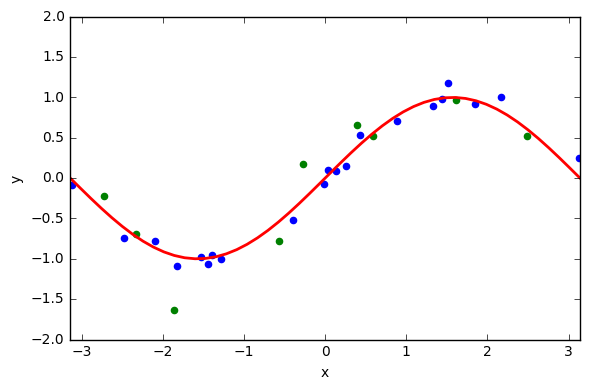

In [4]:
from pylab import *
from sklearn.cross_validation import train_test_split

def gen_data(num_data, sigma):
    x = 2 * np.pi * (np.random.rand(num_data) - 0.5)
    y = np.sin(x) + np.random.normal(0, sigma, num_data)
    return (x, y)

num_data = 30
sigma = 0.2
x, y = gen_data(num_data, sigma)
x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.3, random_state=0)

plt.scatter(x_train, y_train, color='blue')
plt.scatter(x_test, y_test, color='green')

x_grid = np.linspace(-1*np.pi, 1*np.pi)
sin_x = np.sin(x_grid)
plt.plot(x_grid, sin_x, color ='red', linewidth = 2)

plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-np.pi, np.pi)
plt.ylim(-2, 2)
plt.tight_layout()
plt.savefig('./output/fig-dataset-sin.png', dpi=300)
plt.show()

The blue points are training examples and the green ones are testing points. The red curve is the $\sin$ function, which is the function $f^*$ that has the minimal generalization error $C[f^*]$ (called the Bayes error).

In regression, the degree $P$ of a polynomial (polynomial regression) and the depth of a decision tree (decision tree regression) are both hyperparameters that relate to model complexity. Let's consider the polynomial regression here and fit polynomials of degrees $1$, $5$, and $10$ to 20 randomly generated training data of the same distribution:

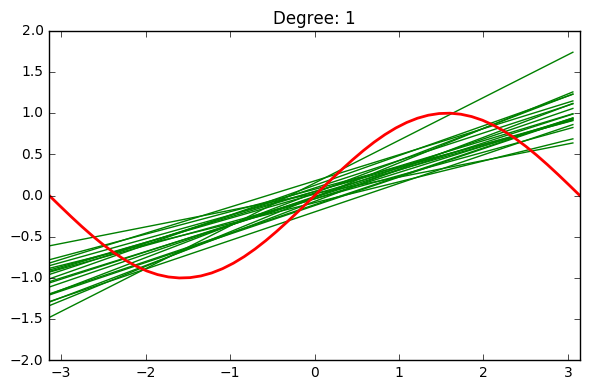

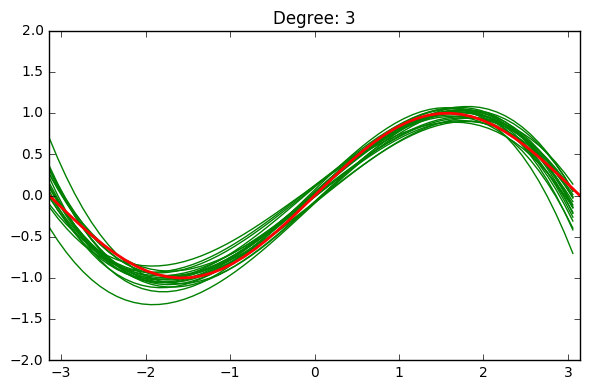

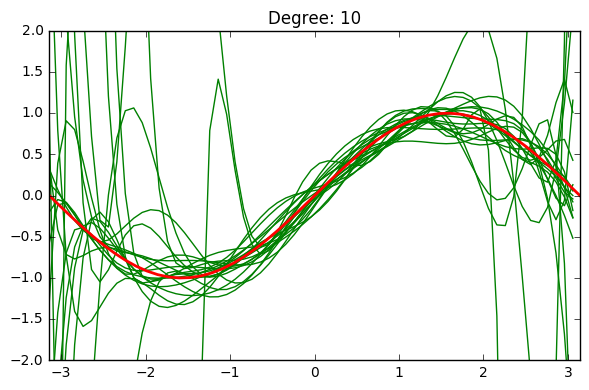

In [6]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

degree = [1, 3, 10]
std_list = []
for d in degree:
    X_fit = np.arange(-np.pi, np.pi, .1)[:, np.newaxis]
    poly = PolynomialFeatures(degree=d)
    
    for i in range(20):
        x, y = gen_data(num_data, sigma)
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=0.3, random_state=0)
        
        regr = LinearRegression()
        regr = regr.fit(poly.fit_transform(x_train[:,np.newaxis]), 
                        y_train[:,np.newaxis])

        y_fit = regr.predict(poly.transform(X_fit))
        plt.plot(X_fit, y_fit, 
                 color='green', lw=1)
    
    x_grid = np.linspace(-1*np.pi, 1*np.pi)
    sin_x = np.sin(x_grid)
    plt.plot(x_grid, sin_x, color='red', linewidth = 2)
    
    plt.title('Degree: %d' %d)
    plt.xlim(-np.pi, np.pi)
    plt.ylim(-2, 2)
    plt.tight_layout()
    plt.savefig('./output/fig-polyreg-%d.png' % d, dpi=300)
    plt.show()

When $P=1$, the polynomial is too simple to capture the trend of the $\sin$ function. On the other hand, when $P=10$, the polynomial becomes too complex such that it captures the undesirable patterns of noises. 

NOTE: regression is bad at extrapolation. You can see that the shape of a fitted polynomial differs a lot from the $\sin$ function outside the region where training points reside.

#### Error Curves and Model Complexity

Let's plot the training and testing errors over different model complexities: 

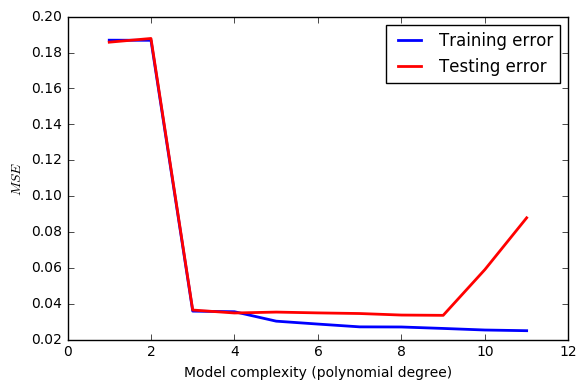

In [7]:
from sklearn.metrics import mean_squared_error

num_data = 50
x, y = gen_data(num_data, sigma)
x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.3, random_state=0)

mse_train = []
mse_test = []

max_degree = 12

for d in range(1, max_degree):
    poly = PolynomialFeatures(degree=d)
    X_train_poly = poly.fit_transform(x_train[:,newaxis])
    X_test_poly = poly.transform(x_test[:,newaxis])
    
    regr = LinearRegression()
    regr = regr.fit(X_train_poly, y_train)
    y_train_pred = regr.predict(X_train_poly)
    y_test_pred = regr.predict(X_test_poly)
    
    mse_train.append(mean_squared_error(y_train, y_train_pred))
    mse_test.append(mean_squared_error(y_test, y_test_pred))
    

plt.plot(range(1, max_degree), mse_train, label = 'Training error', color = 'blue', linewidth = 2)
plt.plot(range(1, max_degree), mse_test, label = 'Testing error', color = 'red', linewidth = 2)
plt.legend(loc='upper right')
plt.xlabel('Model complexity (polynomial degree)')
plt.ylabel('$MSE$')
plt.tight_layout()
plt.savefig('./output/fig-error-curve.png', dpi=300)
plt.show()

We can see that the training error (blue curve) decrease as the model complexity increases. However, the testing error (red curve) decreases at the beginning but increases latter. We see a clear bias-variance tradeoff as discussed in the lecture. 

#### Learning Curves and Sample Complexity

The bias-variance tradeoff holds only when you have sufficient training examples. The bounding methods of learning theory tell us that a model is likely to overfit **regardless of it complexity** when the training set is small. Let's validate this using the learning curves:

In [10]:
def mse(model, X, y):
    return ((model.predict(X) - y)**2).mean()

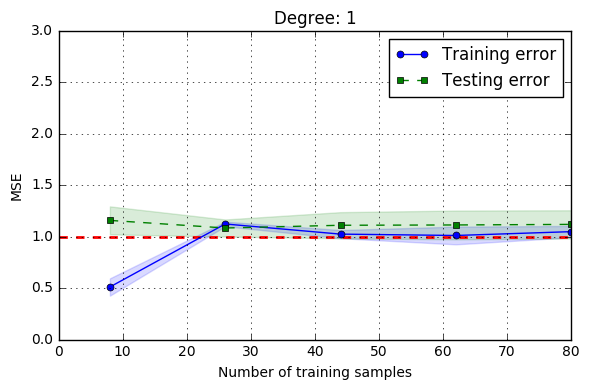

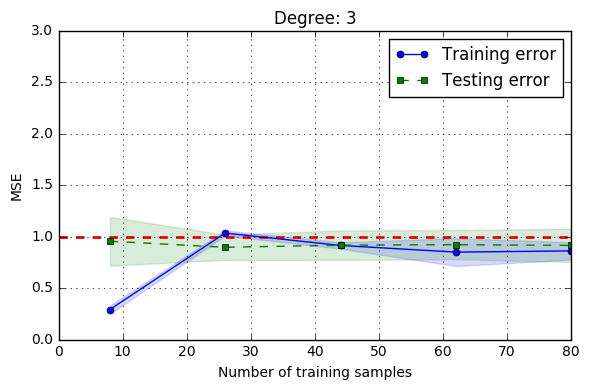

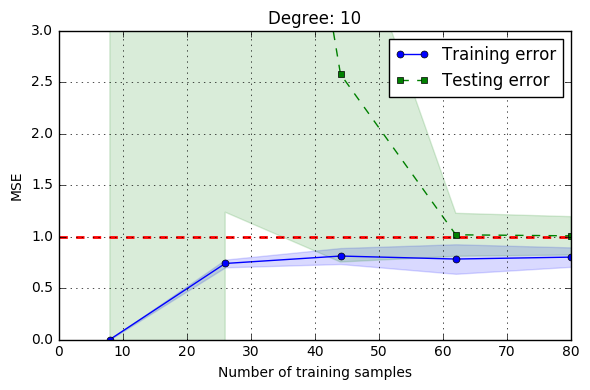

In [12]:
from sklearn.learning_curve import learning_curve

num_data = 120
sigma = 1
degree = [1, 3, 10]
x, y = gen_data(num_data, sigma)
for d in degree:
    poly = PolynomialFeatures(degree=d)
    X = poly.fit_transform(x[:,np.newaxis])

    lr = LinearRegression()
    train_sizes, train_scores, test_scores = learning_curve(estimator=lr, X=X, y=y, scoring=mse)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean,
        color='blue', marker='o',
        markersize=5,
        label='Training error')
    plt.fill_between(train_sizes,
        train_mean+train_std,
        train_mean-train_std,
        alpha=0.15, color='blue')
    
    plt.plot(train_sizes, test_mean,
        color='green', linestyle='--',
        marker='s', markersize=5,
        label='Testing error')
    plt.fill_between(train_sizes,
        test_mean+test_std,
        test_mean-test_std,
        alpha=0.15, color='green')
    
    plt.hlines(y=1, xmin=0, xmax=80, color='red', linewidth=2, linestyle='--')
    
    plt.title('Degree: %d' % d)
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('MSE')
    plt.legend(loc='upper right')
    plt.ylim([0, 3])
    plt.tight_layout()
    plt.savefig('./output/fig-learning-curve-%d.png' % d, dpi=300)
    plt.show()

On the other hand, if you use large number of training data, you the overfitting problem may not be significant.

## Weigh Decay

Weight decay is a common regularization approach. The idea is to add a term in the cost function against complexity.
In regression, this leads to two well-known models:

Ridge regression:
$$\arg\min_{\boldsymbol{w},b}\Vert\boldsymbol{y}-(\boldsymbol{X}\boldsymbol{w}-b\boldsymbol{1})\Vert^{2}+\alpha\Vert\boldsymbol{w}\Vert^{2}$$

LASSO:
$$\arg\min_{\boldsymbol{w},b}\Vert\boldsymbol{y}-(\boldsymbol{X}\boldsymbol{w}-b\boldsymbol{1})\Vert^{2}+\alpha\Vert\boldsymbol{w}\Vert_{1}$$

Let's see how they work using the Housing dataset: 

In [14]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
                 'housing/housing.data',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Remember that for weight decay to work properly, we need to ensure that all our features are on comparable scales:

In [16]:
from sklearn.preprocessing import StandardScaler

X = df.iloc[:, :-1].values
y = df['MEDV'].values

sc_x = StandardScaler()
X_std = sc_x.fit_transform(X)

#### Ridge Regression

We know that an unregularized polynomial regressor with degree $P=3$ will overfit the training data and has bad generalizability. Let's regularize its $L^2$-norm to see if we can get a better testing error:

In [18]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_std)
X_train, X_test, y_train, y_test = train_test_split(
    X_poly, y, test_size=0.3, random_state=0)

for a in [0, 1, 10, 100, 1000]:
    lr_rg = Ridge(alpha=a)
    lr_rg.fit(X_train, y_train)

    y_train_pred = lr_rg.predict(X_train)
    y_test_pred = lr_rg.predict(X_test)

    print('\n[Alpha = %d]' % a )
    print('MSE train: %.2f, test: %.2f' % (
                    mean_squared_error(y_train, y_train_pred),
                    mean_squared_error(y_test, y_test_pred)))  



[Alpha = 0]
MSE train: 0.00, test: 19958.68

[Alpha = 1]
MSE train: 0.73, test: 23.05

[Alpha = 10]
MSE train: 1.66, test: 16.83

[Alpha = 100]
MSE train: 3.60, test: 15.16

[Alpha = 1000]
MSE train: 8.81, test: 19.22


We can see that a small value $\alpha$ drastically reduces the testing error. In addition, $\alpha = 100$ seems to be a good decay strength. As we can see, it's not a good idea to increase $\alpha$ forever, since it will over-shrink the coefficients of $\boldsymbol{w}$ and result in underfit.

Let's see the rate of weight decay as $\alpha$ grows:

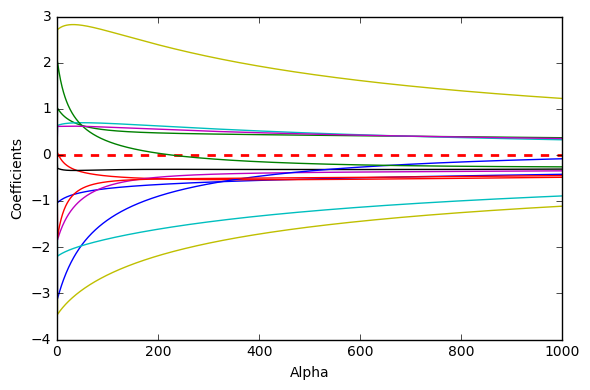

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_std, y, test_size=0.3, random_state=0)

max_alpha = 1000
coef_ = np.zeros((max_alpha, 13))

for a in range(1, max_alpha):
    lr_rg = Ridge(alpha=a)
    lr_rg.fit(X_train, y_train)

    y_train_pred = lr_rg.predict(X_train)
    y_test_pred = lr_rg.predict(X_test)
    coef_[a,:] = lr_rg.coef_.reshape(1,-1)
    
plt.hlines(y=0, xmin=0, xmax=max_alpha, color='red', linewidth = 2, linestyle = '--')

for i in range(13):
    plt.plot(range(max_alpha),coef_[:,i])
    
plt.ylabel('Coefficients')
plt.xlabel('Alpha')
plt.tight_layout()
plt.savefig('./output/fig-ridge-decay.png', dpi=300)
plt.show()

#### LASSO

An alternative weight decay approach that can lead to sparse $\boldsymbol{w}$ is the LASSO. Depending on the value of $\alpha$, certain weights can become zero much faster than others, which makes the LASSO also useful as a supervised feature selection technique.

NOTE: since $L^1$-norm has non differentiable points, the solver (optimization method) is different from the one used in the Ridge regression. It would take much more time to train model weights.

In [23]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

for a in [0.001, 0.01, 0.1, 1, 10]:
    lr_rg = Lasso(alpha=a)
    lr_rg.fit(X_train, y_train)

    y_train_pred = lr_rg.predict(X_train)
    y_test_pred = lr_rg.predict(X_test)

    print('\n[Alpha = %.2f]' % a )
    print('MSE train: %.2f, test: %.2f' % (
                    mean_squared_error(y_train, y_train_pred),
                    mean_squared_error(y_test, y_test_pred)))  


[Alpha = 0.00]
MSE train: 19.96, test: 27.20

[Alpha = 0.01]
MSE train: 19.96, test: 27.28

[Alpha = 0.10]
MSE train: 20.42, test: 28.33

[Alpha = 1.00]
MSE train: 26.04, test: 33.41

[Alpha = 10.00]
MSE train: 84.76, test: 83.77


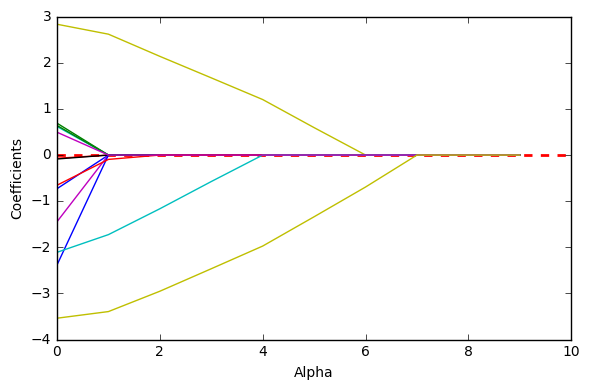

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X_std, y, test_size=0.3, random_state=0)

max_alpha = 10
coef_ = np.zeros((max_alpha,13))

for a in range(10):
    lr_rg = Lasso(alpha=a+0.1)
    lr_rg.fit(X_train, y_train)

    y_train_pred = lr_rg.predict(X_train)
    y_test_pred = lr_rg.predict(X_test)
    coef_[a,:] = lr_rg.coef_.reshape(1,-1)
    
plt.hlines(y=0, xmin=0, xmax=max_alpha, color='red', linewidth = 2, linestyle = '--')

for i in range(13):
    plt.plot(range(max_alpha),coef_[:,i])
    
plt.ylabel('Coefficients')
plt.xlabel('Alpha')
plt.tight_layout()
plt.savefig('./output/fig-ridge-decay.png', dpi=300)
plt.show()

The result shows that as the $\alpha$ increases, the coefficients shrink **faster** and become **exactly zero** when $\alpha=8$.


#### LASSO for Feature Selection

Since we can choose a suitable regularization strength $\alpha$ to make only part of coefficients become exactly zeros, LASSO can also be treated as a feature selection technique.

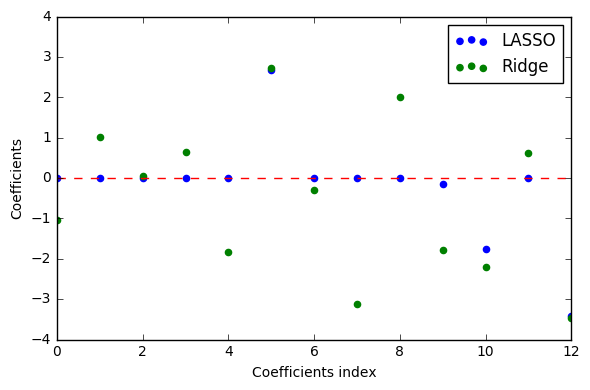

Selected attributes: ['RM' 'TAX' 'PTRATIO' 'LSTAT']


In [27]:
var_num = X_train.shape[1]

lr_lasso = Lasso(alpha = 1)
lr_lasso.fit(X_train, y_train)
lr_ridge = Ridge(alpha = 1)
lr_ridge.fit(X_train, y_train)

plt.scatter(range(var_num),lr_lasso.coef_, label = 'LASSO', color = 'blue')
plt.scatter(range(var_num),lr_ridge.coef_, label = 'Ridge', color = 'green')
plt.hlines(y=0, xmin=0, xmax=var_num-1, color='red', linestyle ='--')
plt.xlim(0,12)
plt.legend(loc = 'upper right')
plt.xlabel('Coefficients index')
plt.ylabel('Coefficients')
plt.tight_layout()
plt.show()

epsilon = 1e-4
idxs = np.where(abs(lr_lasso.coef_) > epsilon)
print('Selected attributes: {}'.format(df.columns.values[idxs]))

We can plot the pairwise distributions to see the correlation between the selected attributes and `MEDV`: 

All attributes:


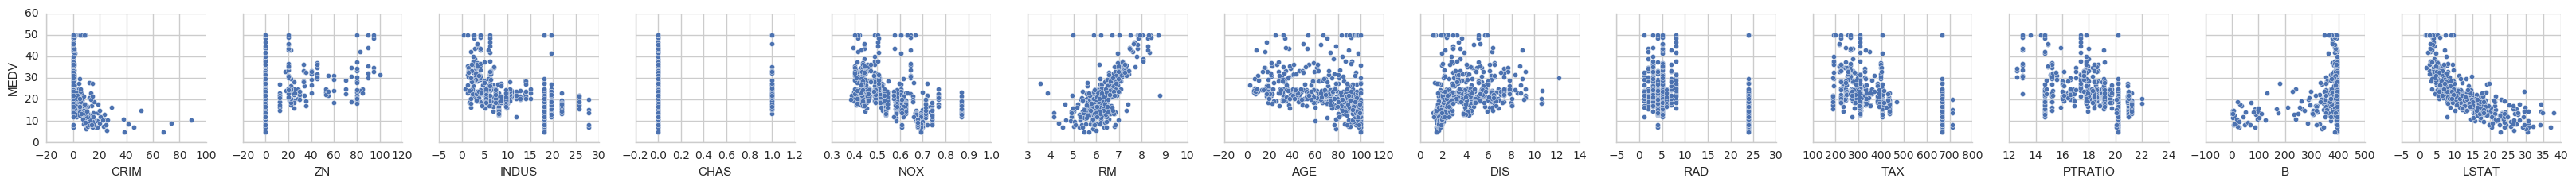

Selected attributes:


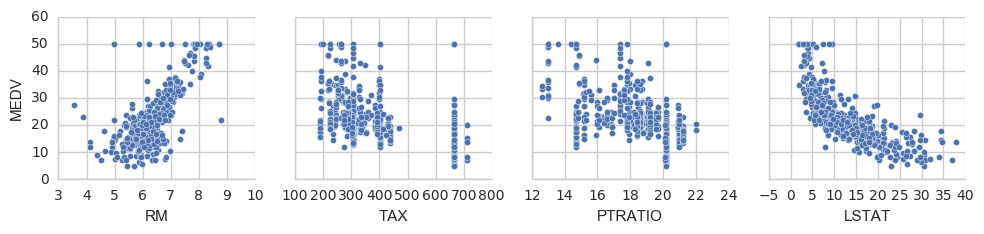

In [29]:
import seaborn as sns

print('All attributes:')
sns.set(style='whitegrid', context='notebook')
sns.pairplot(df, x_vars=df.columns[:-1], y_vars=['MEDV'], size=2.5)
plt.tight_layout()
plt.show()

print('Selected attributes:')
sns.set(style='whitegrid', context='notebook')
sns.pairplot(df,x_vars=df.columns[idxs], y_vars=['MEDV'], size=2.5)
plt.tight_layout()
plt.show()
sns.reset_orig()

As we can see, LASSO extracted attributes that have more significant correlations with `MEDV`.


#### Ignoring with Outliers using RANSAC

Linear regression models can be heavily impacted by the presence of outliers. In certain situations, a very small subset of our data can have a big effect on the estimated model coefficients. There are many statistical tests that can be used to detect outliers, which are beyond the scope of our course. However, removing outliers always requires our own judgment as a data scientist, as well as our domain knowledge.

As an alternative to throwing out outliers, we will look at a robust method of regression using the RANdom SAmple Consensus (RANSAC) algorithm, which fits a regression model to a subset of the data, the so-called inliers. We can summarize the iterative RANSAC algorithm as follows:
1.  Select a random number of samples to be inliers and fit the model.
2.  Test all other data points against the fitted model and add those points that fall within a user-given tolerance to the inliers.
3.  Refit the model using all inliers.
4.  Estimate the error of the fitted model versus the inliers.
5.  Terminate the algorithm if the performance meets a certain user-defined threshold or if a fixed number of iterations has been reached; go back to step 1 otherwise.

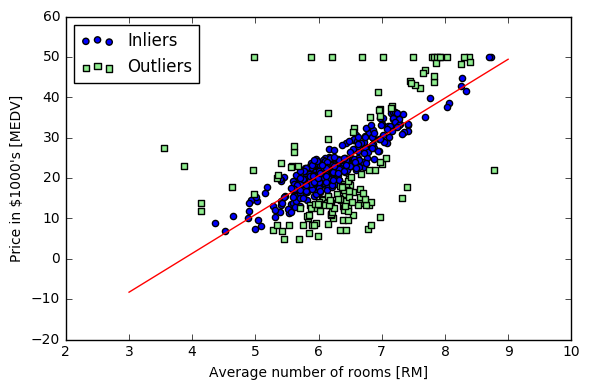


[RANSAC]
Slope (w_1): 9.62    Intercept (w_0): -37.14

[Ordinary least square]
Slope (w_1): 9.10    Intercept (w_0): -34.67


In [31]:
from sklearn.linear_model import RANSACRegressor

X = df['RM'].values[:, np.newaxis]
y = df['MEDV'].values

ransac = RANSACRegressor(LinearRegression(), 
            max_trials=100, 
            min_samples=50, 
            residual_threshold=5.0, 
            random_state=0)
ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask], 
            c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
print('\n[RANSAC]')
print('Slope (w_1): {:.2f}    Intercept (w_0): {:.2f}'.format(ransac.estimator_.coef_[0],ransac.estimator_.intercept_))


slr = LinearRegression()
slr.fit(X, y)
print('\n[Ordinary least square]')
y_pred = slr.predict(X)
print('Slope (w_1): {:.2f}    Intercept (w_0): {:.2f}'.format(slr.coef_[0],slr.intercept_))


We set the maximum number of iterations of the `RANSACRegressor` to 100, and via the `min_samples` parameter we set the minimum number of the randomly chosen samples to be at least 50. Using the `residual_metric` parameter, we provided a callable lambda function that simply calculates the absolute vertical distances between the fitted line and the sample points. By setting the `residual_threshold` parameter to 5.0, we only allowed samples to be included in the inlier set if their vertical distance to the fitted line is within 5 distance units, which works well on this  particular dataset. By default, scikit-learn uses the the Median Absolute Deviation (MAD) estimate of the target values $y$ to select the inlier threshold. However, the choice of an appropriate value for the inlier threshold is problem-specific, which is one disadvantage of RANSAC. Many different approaches have been developed over the recent years to select a good inlier threshold automatically. 


## Validation


Validation is useful to decide proper value of a **hyperparameter**, which may have impact on the model complexity and generalization performance. The idea is to split your data into the training, validation, and testing sets and then select the value based on the **validation performance**. So, you don't peep testing set and report optimistic testing performance.

Let's follow the structural risk minimization framework to pick a right degree $P$ in polynomial regression:

In [33]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

X = df.iloc[:, :-1].values
y = df['MEDV'].values

sc_x = StandardScaler()
X_std = sc_x.fit_transform(X)

for d in range(1, 7):
    poly = PolynomialFeatures(degree=d)
    X_poly = poly.fit_transform(X_std)

    #mind that there are two splits
    X_train, X_test, y_train, y_test = train_test_split(
        X_poly, y, test_size=0.3, random_state=0)
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=0.3, random_state=0)
    
    rg = Ridge(alpha=100)
    rg.fit(X_train, y_train)
    
    y_train_pred = rg.predict(X_train)
    y_valid_pred = rg.predict(X_valid)
    y_test_pred = rg.predict(X_test)
    
    print('\n[Degree = %d]' % d)
    print('MSE train: %.2f, valid: %.2f, test: %.2f' % (
                    mean_squared_error(y_train, y_train_pred),
                    mean_squared_error(y_valid, y_valid_pred),
                    mean_squared_error(y_test, y_test_pred))) 


[Degree = 1]
MSE train: 25.00, valid: 21.43, test: 32.09

[Degree = 2]
MSE train: 9.68, valid: 14.24, test: 20.24

[Degree = 3]
MSE train: 3.38, valid: 17.74, test: 18.63

[Degree = 4]
MSE train: 1.72, valid: 16.67, test: 30.98

[Degree = 5]
MSE train: 0.97, valid: 59.73, test: 57.02

[Degree = 6]
MSE train: 0.60, valid: 1444.08, test: 33189.41


We pick $P=2$ because it gives a low enough validation error at the simplest complexity. Then, we report the testing error over the test set. In general, you may not be able to pick the $P$ that gives the lowest testing performance. In this case you get the 20.24% testing error instead of 18.63%. But that's the right way to do error reporting.